In [44]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import datetime

In [45]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [46]:
tagged_pitch_types = all_pitches['TaggedPitchType'].unique()
print(tagged_pitch_types)

auto_pitch_types = all_pitches['AutoPitchType'].unique()
print(auto_pitch_types)

['Fastball' 'Slider' 'ChangeUp' 'Curveball' 'Cutter' 'Splitter' 'Sinker'
 'Undefined' 'Other' 'FourSeamFastBall' 'Knuckleball' 'OneSeamFastBall'
 'TwoSeamFastBall']
['Four-Seam' 'Slider' 'Sinker' 'Changeup' 'Curveball' 'Cutter' nan 'Other'
 'Splitter']


In [47]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]

print(fastballs.shape)

(152663, 167)


In [48]:
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)

/tmp/ipykernel_8328/409369648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)


In [49]:
fb_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [50]:
fastballs_X = fastballs[fb_preds]
fastballs_y = fastballs['whiff']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(fastballs_X, fastballs_y, test_size=.33, random_state=25)

# Set up the XGBoost model
xgb_model = XGBClassifier(random_state=25)

# Define the parameter space for Bayesian hyperparameter tuning for XGBoost
param_space = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Learning rate
    'max_depth': (3, 10),  # Maximum depth of a tree
    'n_estimators': (50, 300),  # Number of boosting rounds
    'subsample': (0.6, 1.0),  # Subsample ratio of the training instances
    'colsample_bytree': (0.6, 1.0),  # Subsample ratio of columns for each tree
    'gamma': (0, 10),  # Minimum loss reduction required to make a further partition
    'reg_alpha': (1e-8, 1.0, 'log-uniform'),  # L1 regularization term
    'reg_lambda': (1e-8, 1.0, 'log-uniform'),  # L2 regularization term
}

# Set up Bayesian search using BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=25,  # Number of iterations
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=0,
    random_state=42
)

# Fit the model using Bayesian hyperparameter tuning
bayes_search.fit(X_train, y_train)

# Best hyperparameters found
best_params = bayes_search.best_params_
print(f"Best hyperparameters for Whiffs: {best_params}")

# Make predictions on the training and test sets using the best model
best_model = bayes_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate MSE and R-squared for both training and test sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'Accuracy (Training): {accuracy_train:.4f}')
print(f'ROC AUC (Training): {auc_train:.4f}')
print(f'Accuracy (Test): {accuracy_test:.4f}')
print(f'ROC AUC (Test): {auc_test:.4f}')


Best hyperparameters for Whiffs: OrderedDict({'colsample_bytree': 0.932060300601922, 'gamma': 0, 'learning_rate': 0.022521035420373585, 'max_depth': 9, 'n_estimators': 159, 'reg_alpha': 0.0060558313320077575, 'reg_lambda': 0.007113828972943507, 'subsample': 0.8845303608356287})
Accuracy (Training): 0.9108
ROC AUC (Training): 0.5067
Accuracy (Test): 0.9086
ROC AUC (Test): 0.5002


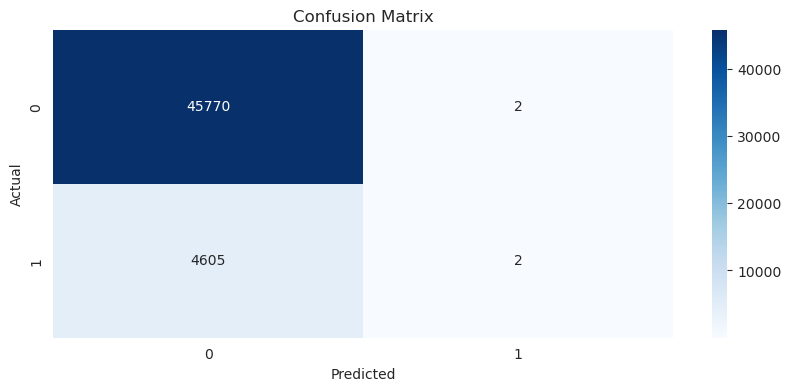

In [11]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7043
Recall: 0.5002
F1 Score: 0.4765


ROC AUC: 0.5002


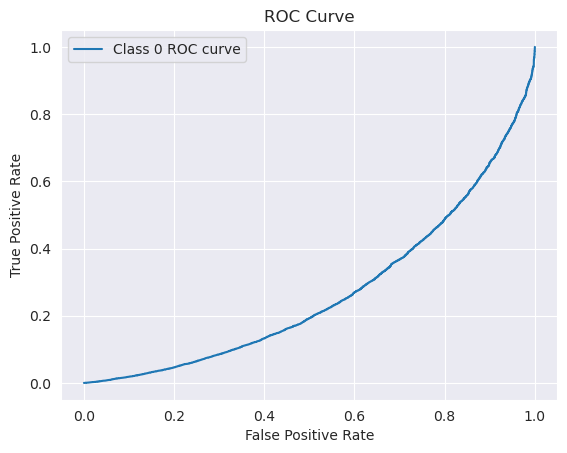

In [14]:
y_pred_prob = best_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 0, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

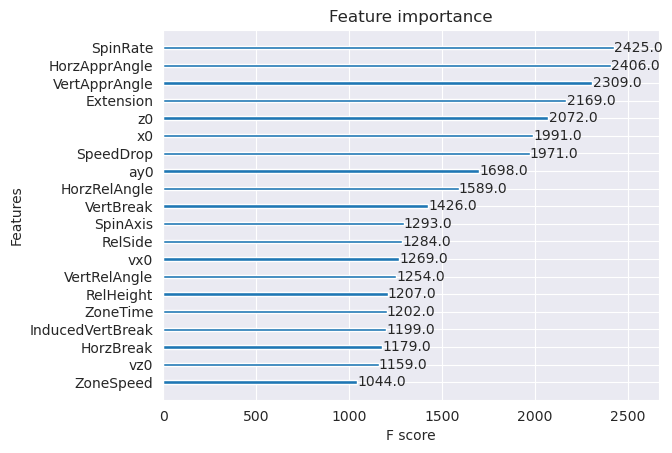

In [15]:
xgboost.plot_importance(best_model, max_num_features=20)

100%|===================| 102204/102284 [17:35<00:00]       

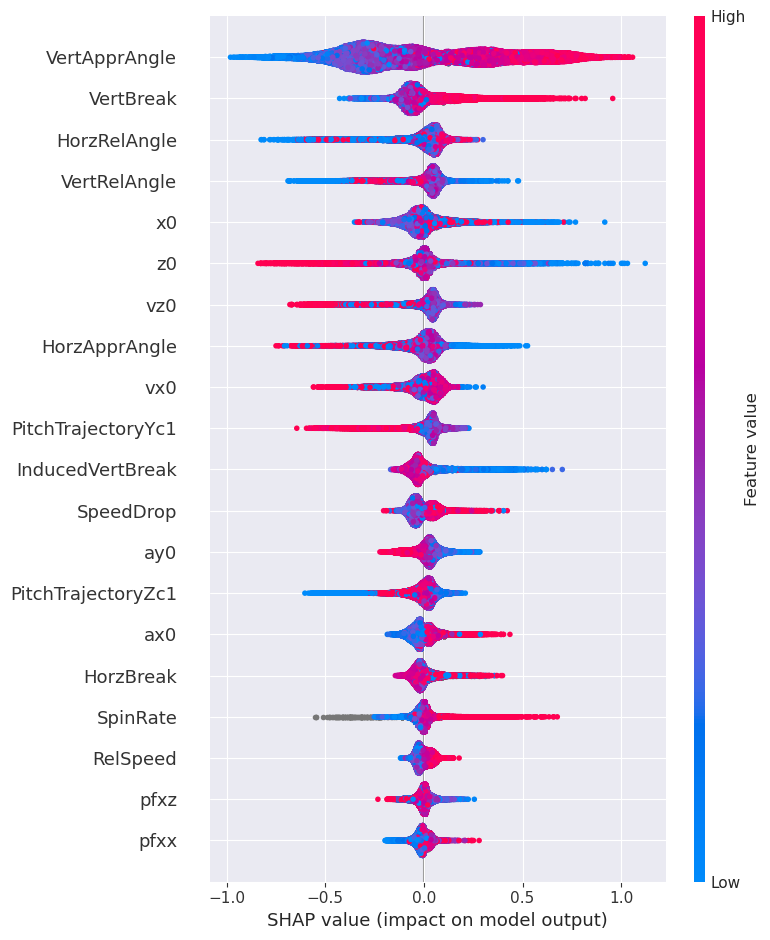

In [16]:
# Step 1: Initialize the SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# Step 2: Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Step 3: Plot a summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

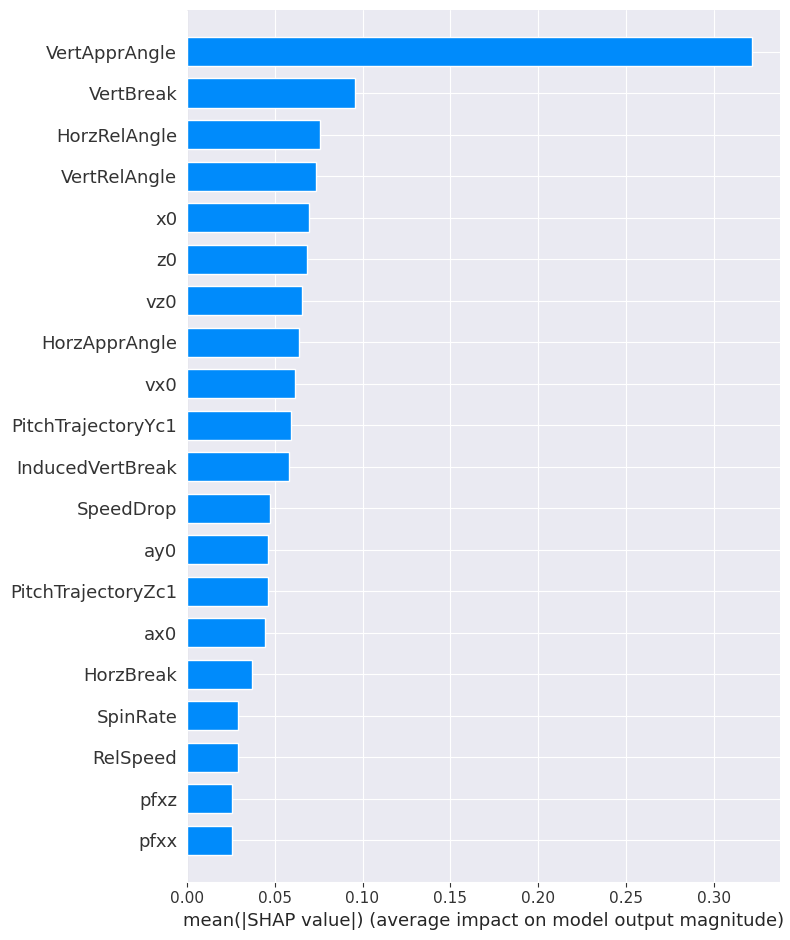

In [17]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type='bar')

In [33]:
fastballs['Date'] = pd.to_datetime(fastballs['Date'], format = 'mixed')

/tmp/ipykernel_8328/1283691197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['Date'] = pd.to_datetime(fastballs['Date'], format = 'mixed')


In [35]:
aub_fbs_2024 = fastballs[(fastballs['PitcherTeam']=='AUB_TIG') & 
                         (fastballs['Date'] > datetime.datetime(2024, 1, 1))]

In [36]:
# Get unique values
unique_values = fastballs['Pitcher'].unique()
aub_unique_values = aub_fbs_2024['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fastballs[fastballs['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: aub_fbs_2024[aub_fbs_2024['Pitcher'] == value] for value in aub_unique_values}

['Myers, Carson' 'Tilly, Cameron' 'Allsup, Chase' 'McBride, Connor'
 'Carlson, Parker' 'Graves, Griffin' 'Watts, Dylan' 'Keshock, Cameron'
 'Murphy, Hayden' 'Crotchfelt, Zach' 'Bauman, Tanner' 'Armstrong, John'
 'Petrovic, Alexander' 'Schorr, Ben' 'Cannon, Will'
 'Herberholz, Christian' 'Nelson, Drew' 'Copeland, Konner'
 'Gonzalez, Joseph' 'Keplinger, Konner']


In [55]:
def aub_fbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = best_model.predict_proba(fastballs_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = best_model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} Fastball stuff+: {np.mean(stuff * 100)}")


In [56]:
for pitcher in aub_unique_values:
    aub_fbs_stuff(pitcher)

Myers, Carson Fastball stuff+: 74.95327758789062
Tilly, Cameron Fastball stuff+: 98.04027557373047
Allsup, Chase Fastball stuff+: 124.42918395996094
McBride, Connor Fastball stuff+: 117.55502319335938
Carlson, Parker Fastball stuff+: 81.21304321289062
Graves, Griffin Fastball stuff+: 136.23109436035156
Watts, Dylan Fastball stuff+: 84.20777130126953
Keshock, Cameron Fastball stuff+: 83.80597686767578
Murphy, Hayden Fastball stuff+: 96.43782806396484
Crotchfelt, Zach Fastball stuff+: 110.61324310302734
Bauman, Tanner Fastball stuff+: 101.07666015625
Armstrong, John Fastball stuff+: 91.09601593017578
Petrovic, Alexander Fastball stuff+: 80.22306823730469
Schorr, Ben Fastball stuff+: 78.04396057128906
Cannon, Will Fastball stuff+: 110.12942504882812
Herberholz, Christian Fastball stuff+: 107.5452880859375
Nelson, Drew Fastball stuff+: 84.9781265258789
Copeland, Konner Fastball stuff+: 75.30965423583984
Gonzalez, Joseph Fastball stuff+: 82.94123840332031
Keplinger, Konner Fastball stuff+: 

Now, we can save the model to be accessed by the dash app

In [39]:
import joblib

joblib.dump(best_model, '../../models/fastballs_model.pkl')

['../../models/fastballs_model.pkl']